In [4]:
# CNN_8_7
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., I. Halperin and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 
# Notebook adapted from solution provided by Noah Grudowski. 

### Load Necessary Packages

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.models import load_model
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten

Using TensorFlow backend.


### Load HFT Data

In [5]:
df = pd.read_csv('../../data/HFT.csv')

In [6]:
df.head()

feature_1  feature_2  feature_3  label
0   0.515301       0.72   0.710953      0
1   0.515301       0.72   0.710953      0
2   0.515301       0.72   0.710953      0
3   0.515301       0.72   0.710953      0
4   0.515301       0.72   0.710953      0

We consider a univariate prediction problem where the time series is given by 'feature_3' in the data frame.

In [7]:
use_features = 'feature_3' # continuous input
target = 'feature_3' # continuous output

## Part a: Stationarity with Augmented Dickey-Fuller Test

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the computation time of the test.

In [8]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df[use_features][:200000])

In [9]:
print(adf, p, usedlag, nobs, cvs,aic)

-3.970572659864007 0.0015726872209325432 80 199919 {'1%': -3.430382710167448, '5%': -2.8615544574611698, '10%': -2.566777695186804} -1679778.349426464


Looking at the above output, we have a test statistic of -3.97057.  Thus, we reject the null hypothesis, as there is reasonable evidence to conclude that this dataset is stationary.

## Part b: Estimate Partial Auto-Correlation Function and Determine Optimum Lag (99% Confidence)
The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where T is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimat the PACF. The 'nlags' parameter is the maximum number of lags used for PACF estimation.

In [10]:
pacf=sm.tsa.stattools.pacf(df[use_features], nlags=30)

In [11]:
pacf

array([1.        , 0.99978073, 0.00645883, 0.02457632, 0.02450646,
       0.01566672, 0.01228706, 0.01406852, 0.00552327, 0.01106975,
       0.0097814 , 0.00528616, 0.00271307, 0.00482261, 0.00514608,
       0.01184934, 0.0107241 , 0.00366119, 0.00550863, 0.00744828,
       0.00379451, 0.00335972, 0.00854415, 0.00654713, 0.00155662,
       0.00443114, 0.00538996, 0.00230699, 0.00812299, 0.00166796,
       0.00477462])

In [2]:
n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df[use_features])))==False)[0][0] -1
#Note that a z-score of 2.58 corresponds to the 99% confidence interval

In [13]:
print(n_steps)

23


Thus, we have shown that the optimum lag at the 99% confidence level is 23. Note that this value for the number of lags is a little high, and may be more than necessary. Thus, this could unnaturally lead to a high order model.

## Preparing Data for Parts c, d, and e
### Splitting and Scaling

This may lead to a high order model, with more lags than strictly necessary. We could view this value, informally, as an upper bound on the number of lags needed. We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of 2 lags appears satisfactory, although more may be needed. Unlike autoregressive models, the advantage of using fewer parameters is purely computational as adding more lags does not increase the number of parameters, only the size of the tensorial representation of the sequence data in TensorFlow. 

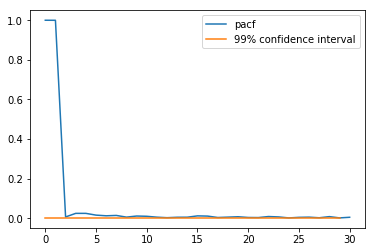

In [14]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval')
plt.legend()

### Splitting
Split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [16]:
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df.iloc[:split]

### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [17]:
mu = np.float(df_train[use_features].mean())
sigma = np.float(df_train[use_features].std())

In [18]:
std_df_train = df_train[use_features].apply(lambda x: (x - mu) / sigma)

In [20]:
df_test = df.iloc[split:]
std_df_test = df[use_features].apply(lambda x: (x - mu) / sigma).iloc[split:]

## Part c: Evaluating MSE in-sample and out-of-sample Using 4 Filters.

As the number of filters is increased, the difference between the out-of-sample and in-sample mean-
squared errors gets noticeably larger. While it can be seen that the in-sample error is minimized, the
out-of-sample error begins to get larger and larger the more the number of filters is increased. This can
be explained by the Bias-Variance tradeoff, as the increased number of filters is causing the model to
become overfitted. As a result, this increased complexity in the model does minimize the in-sample
error, but in consequence/tradeoff, the out-of-sample error is sacrificed. Put another way, we have a
lower bias but a higher variance in this scenario.

In [21]:
def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        Flatten(),
        Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
    return model

In [22]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q

In [28]:
def evaluate_timeseries(timeseries, window_size):

    filter_length = 5
    nb_filter = 100
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()

    X, y, q = make_timeseries_instances(timeseries, window_size)
    test_size = int(0.01 * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

    pred_out_sample = model.predict(X_test)
    pred_in_sample = model.predict(X_train)
    
    print('Out of Sample Mean Squared Error: ',mean_squared_error(pred_out_sample,y_test))
    print('In Sample Mean Squared Error: ',mean_squared_error(pred_in_sample,y_train))
    
    return model, X_test, y_test

In [29]:
model, X_test, y_test = evaluate_timeseries(std_df_train[:1000], 50)

C:\Users\Noah PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(50, 1), filters=100, kernel_size=5)`
  import sys
C:\Users\Noah PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 46, 100)           600       
_________________________________________________________________
flatten_3 (Flatten)          (None, 4600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4601      
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________
Train on 940 samples, validate on 10 samples
Epoch 1/25
940/940 [==============================] - 1s 1ms/step - loss: 0.0040 - mean_absolute_error: 0.0332 - mean_squared_error: 0.0040 - val_loss: 9.8232e-05 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 9.8232e-05
Epoch 2/25
940/940 [==============================] - 1s 876us/step - loss: 0.0016 - mean_absolute_error: 0.0184 - mean_squar

## Part d: Apply $L_1$ Regularization to Reduce the Variance

𝐿_1 regularization was applied using a 𝜆 parameter that ranged from values between 0.01 and 1. As the
value for 𝜆 was increased (but the number of filters was kept constant), we were able to observe a
smaller difference between the out-of-sample and in-sample mean-squared errors than we did in the
previous case. This can also be explained by the Bias-Variance Tradeoff. In this scenario, we have a
higher bias, but a smaller variance. By introducing 𝐿_1 regularization to the model, we have essentially
introduced a bias. As such, we observe higher values for the in-sample mean-squared errors than we
did in the previous case. However, the differences between the in-sample and out-of-sample mean-
squared errors does not increase as much as it did in the previous case, which exemplifies our smaller
variance.

In [32]:
from keras import regularizers

In [33]:
def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):

    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(kernel_regularizer=regularizers.l1(0.1), nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        #Added Kernel Regularizer Here: L1 regularization
        Flatten(),
        Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
   
    return model

In [34]:
def make_timeseries_instances(timeseries, window_size):
   
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q

In [35]:
def evaluate_timeseries(timeseries, window_size):

    filter_length = 5
    nb_filter = 20
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()

    X, y, q = make_timeseries_instances(timeseries, window_size)
    test_size = int(0.01 * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

    pred_out_sample = model.predict(X_test)
    pred_in_sample = model.predict(X_train)
    
    print('Out of Sample Mean Squared Error: ',mean_squared_error(pred_out_sample,y_test))
    print('In Sample Mean Squared Error: ',mean_squared_error(pred_in_sample,y_train))
    
    
    return model

In [36]:
model = evaluate_timeseries(std_df_train[:5000], 50)

C:\Users\Noah PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_regularizer=<keras.reg..., activation="relu", input_shape=(50, 1), filters=20, kernel_size=5)`
  import sys
C:\Users\Noah PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 46, 20)            120       
_________________________________________________________________
flatten_4 (Flatten)          (None, 920)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 921       
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________
Train on 4900 samples, validate on 50 samples
Epoch 1/25
4900/4900 [==============================] - 5s 960us/step - loss: 0.0516 - mean_absolute_error: 0.0414 - mean_squared_error: 0.0045 - val_loss: 0.0055 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 2.5724e-05
Epoch 2/25
4900/4900 [==============================] - 4s 824us/step - loss: 0.0086 - mean_absolute_error: 0.0319 - mean_sq

## Part e: Determine Whether the Model Error is White Noise or Auto-correlated Using Ljung-Box Test.

Conclusion: White Noise. 

Justification: Running the Ljung-Box test on the HFT dataset, we obtain small test statistics, or p-values.
As such, there does not exist sufficient evidence to reject the null hypothesis. Put another way, there
does not exist reasonable evidence to conclude that the model error is autocorrelated, so we fail to
reject the null hypothesis, concluding instead that the model error is white noise.

In [37]:
T=100000

In [38]:
pred_out_sample = model.predict(X_test)

In [39]:
residual = pred_out_sample-y_test

In [40]:
lb,p=sm.stats.diagnostic.acorr_ljungbox(residual, lags=9, boxpierce=False)

In [41]:
lb

array([ 4.61658566,  5.49214988,  5.51013436,  6.04018039,  7.00702677,
        9.10191919, 11.58875067, 17.51495799, 21.0254082 ])

In [42]:
p

array([0.03166421, 0.06417928, 0.13803373, 0.19616761, 0.22011824,
       0.16792682, 0.11492018, 0.02517188, 0.01253808])